<a href="https://colab.research.google.com/github/AkashKV-1998/Detection-and-localization-of-CMFD/blob/main/CMFD_Implementated_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting-up environment:

## Install opencv contrib library for SIFT feature detector:

In [1]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 10.4 MB/s 
     |████████████████████████████████| 15.7 MB 58.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which

## Link to the drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Path to the directory:

In [3]:
cd /content/drive/MyDrive/M.Tech FYP/FYP_code

/content/drive/MyDrive/M.Tech FYP/FYP_code


## Import all libraries 

In [4]:
from ClusterCall import DBSCAN_Cluster, KMeans_Cluster
from HuThresholdDistribution import Get_Hu_distributions
from SimilarityMeasure import DistanceCalculation
from Metrics import GenerateCM
from Confidence import Confidence_Intervel
import BlockBuilder
from Approximate_Region import Region_Distance
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from skimage import measure
import os
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get thresold distribution 

## Load saved threshold

In [ ]:
try: 
  saved_path = './Outputs/'
  distribution = np.load(saved_path + 'Distribution_Norm_True.npy', allow_pickle=True)
  print('Distribution file is import from directory')
except   FileNotFoundError:
  samples_path = '/content/drive/MyDrive/M.Tech FYP/Test_Files/Test_CoMoFoD_images_samples/Comofod_200_stack.csv'
  data_dir = r'/content/drive/MyDrive/M.Tech FYP/Test_Files/Test_CoMoFoD_images_samples'

  Get_Hu_distributions(samples_path, data_dir, norm=True)
  distribution = np.load(saved_path + 'Distribution_Norm_True.npy', allow_pickle=True)

Distribution file is import from directory


In [ ]:
saved_path = './Outputs/'
distribution = np.load(saved_path + 'Distribution.npy', allow_pickle=True)
distribution

array([[-9.77521709e-06, -1.85260112e-04,  3.15953985e-04,
         1.78268994e-04, -3.33357413e-02, -2.83044508e-02,
        -2.67023304e-02],
       [ 1.07796559e-03,  6.55801775e-01,  7.23326658e-01,
         7.63110134e-01,  1.49748776e+01,  1.66628143e+01,
         2.00357572e+01]])

# Get image and localize forgery if any

##Get test image along with its true binary image for metric calculation

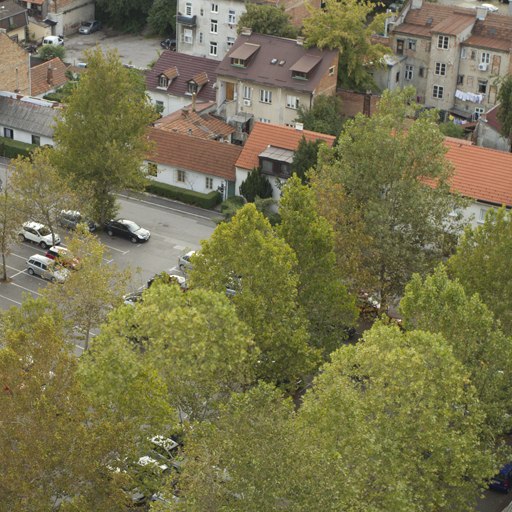

In [ ]:
input = './Inputs/090_F.png'
RealBinary = './Inputs/090_B.png'

cv2_imshow(cv2.imread(input))

##Start detecting forgery regions:

Length of Keypoints from SIFT feature extractor: 2520 and length of descriptors 2520

Delta (minimum distance between pair of blocks) set to : None
Gamma (Sort and take minimum distance ranging from 0 to gamma in every cluster) set to : 20

Detected regions after HuMoments similarity test: 




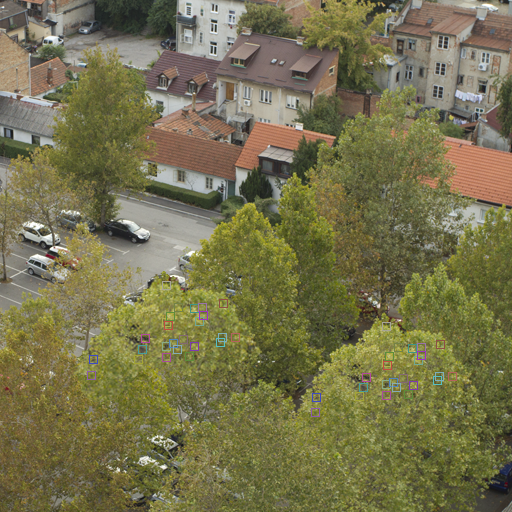

Cluster completed...: 100%|██████████| 77/77 [00:00<00:00, 2549.63it/s]

Number of blocks:  730

Result of CMF after applying region growing: 



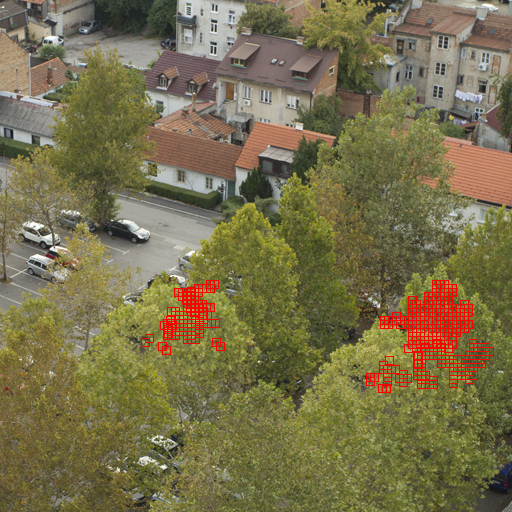


Binary result of CMF after applying region growing: 



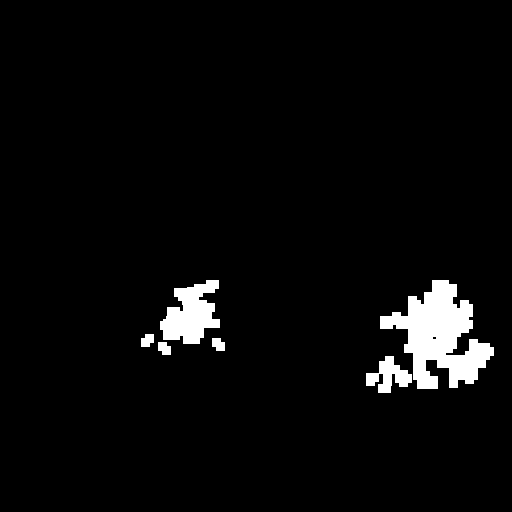


Result: Forgery detected in given image

Confidence of CMF localization: 

Lower Bound: 0.177 
Upper Bound: 2.562


Precision:  0.5554714123438091
Accuracy:  0.8995444444444445
True Positive Rate(TPR):  0.1571673451896293
False Positive Rate(TPR):  0.014553839287928
F1 Score:  0.24501043841336118

Confusion metric: 

+--------------------+--------------------+-------------------+
|                    | Actual_CMF_Regions | False_CMF_Regions |
+--------------------+--------------------+-------------------+
| Actual_CMF_Regions |        1467        |        1174       |
| False_CMF_Regions  |        7867        |       79492       |
+--------------------+--------------------+-------------------+


Comparison between orginal and predicted binary image: 



<Figure size 2880x2880 with 0 Axes>

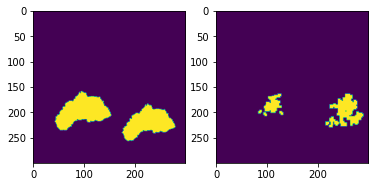

In [ ]:
img = cv2.imread(input)
input_size = (512, 512)
BlockSize  = 4
delta1=7
delta2=100
gamma=20

img = cv2.resize(img, input_size)
Testimage = img.copy()

# start_time = datetime.now()

# cluster_list = KMeans_Cluster(img, n_clusters=3) 
cluster_list = DBSCAN_Cluster(Testimage, eps=60, min_samples=2)

Block = BlockBuilder.BlockBuilding(Testimage, cluster_list, BlockSize=BlockSize)
img_clusters, blocks = Block.CreateBlocks()
# Block.visualize()

CalculateDis = DistanceCalculation(Testimage, blocks, img_clusters, delta=None, gamma=gamma)
ForgeryRegions = CalculateDis.Calculate(method='HuMoments')
# ForgeryRegions = CalculateDis.Calculate(method='Hu_Adapthreshold', distribution=distribution)
path = '/content/drive/MyDrive/M.Tech FYP/FYP_code/Outputs/HuMoments_initial_blocks_Bny.jpg'
# Detection_Result = Region_Distance(img, path=path, delta=delta2)

# if Detection_Result == 'Y':
image = img.copy()
RegionsGrow = BlockBuilder.RegionGrowing(image, ForgeryRegions, delta=delta1, BlockSize=BlockSize)
Forgery_blocks, Forgery_distance = RegionsGrow.Grow(method='HuMoments')
# Size, Total_blocks = RegionsGrow.Grow(method='Hu_Adapthreshold', distribution=distribution)
RegionsGrow.ShowForgery()

lower_bound, upper_bound = Confidence_Intervel(Forgery_distance)

CodeOut = f'{os.getcwd()}/Outputs//CMF_Binary_Result.jpg'
GenerateCM(CodeOut, RealBinary, ['accuracy', 'precision', 'F1', 'TPR', 'FPR'])

# end_time = datetime.now()
# print('Computation time taken for algorithm: {}\n'.format(end_time - start_time))

## Approximated detected area

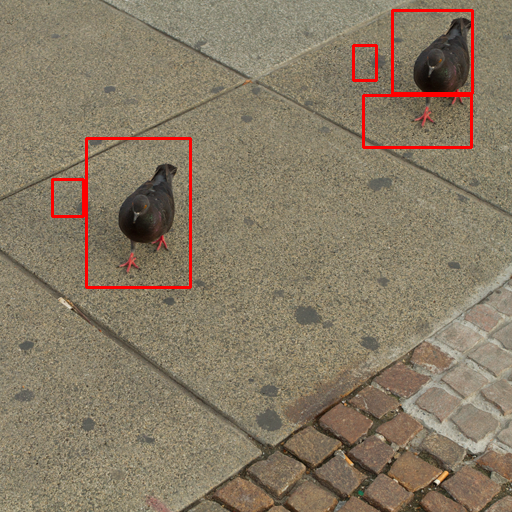

In [ ]:
import imutils
from imutils import contours
from skimage import measure

detected_rgns = cv2.imread('./Outputs/CMF_Binary_Result.jpg')
detected_rgns = cv2.cvtColor(detected_rgns, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(detected_rgns, (15, 15), 0)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

labels = measure.label(thresh, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")
# loop over the unique components
for label in np.unique(labels):
	# if this is the background label, ignore it
	if label == 0:
		continue
	# otherwise, construct the label mask and count the
	# number of pixels 
	labelMask = np.zeros(thresh.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)
	# if the number of pixels in the component is sufficiently
	# large, then add it to our mask of "large blobs"
	if numPixels > 300:
		mask = cv2.add(mask, labelMask)
	
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
if len(cnts) != 0:
	cnts = contours.sort_contours(cnts)[0]
# loop over the contours

forgery_area = []
for (i, c) in enumerate(cnts):
	# draw the bright spot on the image
	(x, y, w, h) = cv2.boundingRect(c)
	cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
	location = img[y:y+h, x:x+w]
	forgery_area.append(location)

# show the output image
cv2_imshow(img)

# Detection Accuracy Analysis:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageEnhance
from PIL import Image 
from itertools import chain
from Analysis import info
import random
%matplotlib inline
import imutils
from imutils import contours
from skimage import measure
from Distance import HuMoments

In [ ]:
path = '/content/drive/MyDrive/M.Tech FYP/CoMoFoD/CoMoFoD_small_v2'

CoMoFoD_dataset = os.listdir(path)

len(CoMoFoD_dataset)

10406

In [ ]:
Samples = []

for sample in CoMoFoD_dataset:
  if 'O.png' in sample:
    Samples.append(sample)

for sample in CoMoFoD_dataset:
  if 'F.png' in sample:
    Samples.append(sample)

CoMoFoD_sample = random.sample(Samples, len(Samples))

In [ ]:
CoMoFoD_sample

##### Adding additional attacks to images

In [ ]:
def add_noise(img):

  gauss = np.random.normal(0, 0,img.size)
  gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
  # Add the Gaussian noise to the image
  img_gauss = cv2.add(img,gauss)
  # Display the image
  # cv2_imshow(img_gauss)

  return img

def add_blur(img):

  img = cv2.GaussianBlur(img, (1,1), cv2.BORDER_DEFAULT)

  return img

def add_bright(img):

  img_pil = Image.fromarray(img)
  converter = ImageEnhance.Brightness(img_pil)
  img_pil = converter.enhance(2)
  img = np.array(img_pil)
  
  return img

def add_sharp(img):

  img_pil = Image.fromarray(img)
  converter = ImageEnhance.Sharpness(img_pil)
  img_pil = converter.enhance(2)
  img = np.array(img_pil)
  
  return img

def add_contrast(img):

  img_pil = Image.fromarray(img)
  converter = ImageEnhance.Contrast(img_pil)
  img_pil = converter.enhance(2)
  img = np.array(img_pil)
  
  return img

def add_saturation(img):

  img_pil = Image.fromarray(img)
  converter = ImageEnhance.Color(img_pil)
  img_pil = converter.enhance(2)
  img = np.array(img_pil)
  
  return img

# cv2_imshow(add_contrast(img))

##### Testing with dataset images and reporting results

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

def CMFD_detection(img):

    img = cv2.resize(img, (512, 512))
    Testimage = img.copy()

    # cluster_list = KMeans_Cluster(img, n_clusters=3) 
    cluster_list = DBSCAN_Cluster(img, eps=60, min_samples=2)

    Block = BlockBuilder.BlockBuilding(img, cluster_list, BlockSize=4)
    img_clusters, blocks = Block.CreateBlocks()

    CalculateDis = DistanceCalculation(img, blocks, img_clusters, gamma=None)
    ForgeryRegions = CalculateDis.Calculate('HuMoments')

    image = Testimage.copy()
    RegionsGrow = BlockBuilder.RegionGrowing(image, ForgeryRegions, delta=3, BlockSize=4)
    Forgery_blocks, Forgery_distance = RegionsGrow.Grow(method='HuMoments')
    RegionsGrow.ShowForgery()

    detected_rgns = cv2.imread('./Outputs/CMF_Binary_Result.jpg')
    detected_rgns = cv2.cvtColor(detected_rgns, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(detected_rgns, (15, 15), 0)
    thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    labels = measure.label(thresh, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")
    # loop over the unique components
    for label in np.unique(labels):
      # if this is the background label, ignore it
      if label == 0:
        continue
      # otherwise, construct the label mask and count the
      # number of pixels 
      labelMask = np.zeros(thresh.shape, dtype="uint8")
      labelMask[labels == label] = 255
      numPixels = cv2.countNonZero(labelMask)
      # if the number of pixels in the component is sufficiently
      # large, then add it to our mask of "large blobs"
      if numPixels > 300:
        mask = cv2.add(mask, labelMask)
      
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) >= 2:
      cnts = contours.sort_contours(cnts)[0]
    else: 
      print('No forgery miss matched regions found in operation...')
      return 
    # loop over the contours

    forgery_area = []
    for (i, c) in enumerate(cnts):
      # draw the bright spot on the image
      (x, y, w, h) = cv2.boundingRect(c)
      cv2.rectangle(Testimage, (x, y), (x + w, y + h), (0, 255, 0), 1)
      location = Testimage[y:y+h, x:x+w]
      forgery_area.append(location)

    # show the output image
    cv2_imshow(Testimage)

    total_final_block = 0
    for f1_index, f1 in enumerate(forgery_area):
      for f2_index, f2 in enumerate(forgery_area):
        if f1_index != f2_index:
          diff = HuMoments(f1, f2)
          
          if diff < 20:
            total_final_block+=1

    block_regiongrow = len(Forgery_blocks)
    Hucalculations = len(ForgeryRegions)

    if total_final_block != 0:
      Forgery = 'Y'
    else:
      Forgery = 'N'
    
    lower, upper = Confidence_Intervel(Forgery_distance)

    return Forgery, Hucalculations, block_regiongrow, (lower, upper)

def Forgery_detection(img):

    img = cv2.resize(img, (512, 512))
    Testimage = img.copy()

    # cluster_list = KMeans_Cluster(img, n_clusters=3) 
    cluster_list = DBSCAN_Cluster(img, eps=60, min_samples=2)

    Block = BlockBuilder.BlockBuilding(img, cluster_list, BlockSize=8)
    img_clusters, blocks = Block.CreateBlocks()

    CalculateDis = DistanceCalculation(img, blocks, img_clusters, gamma=None)
    ForgeryRegions = CalculateDis.Calculate('HuMoments')

    image = Testimage.copy()
    RegionsGrow = BlockBuilder.RegionGrowing(image, ForgeryRegions, delta=2.0, BlockSize=8)
    size, Total_blocks = RegionsGrow.Grow(method='HuMoments')

    lower, upper = Confidence_Intervel(Total_blocks)

    block_regiongrow = len(size)
    Hucalculations = len(ForgeryRegions)

    if block_regiongrow != 0:
      Forgery = 'Y'
    else:
      Forgery = 'N'

    return Forgery, Hucalculations, block_regiongrow, (lower, upper)


def Imp_forgery_detection(img):

    input_size = (512, 512)
    BlockSize  = 10
    delta1=3.2
    delta2=2
    gamma=10

    img = cv2.resize(img, input_size)
    Testimage = img.copy()

    # start_time = datetime.now()

    # cluster_list = KMeans_Cluster(img, n_clusters=3) 
    cluster_list = DBSCAN_Cluster(Testimage, eps=60, min_samples=2)

    Block = BlockBuilder.BlockBuilding(Testimage, cluster_list, BlockSize=BlockSize)
    img_clusters, blocks = Block.CreateBlocks()
    # Block.visualize()

    CalculateDis = DistanceCalculation(Testimage, blocks, img_clusters, gamma=gamma)
    ForgeryRegions = CalculateDis.Calculate(method='HuMoments')
    # ForgeryRegions = CalculateDis.Calculate(method='Hu_Adapthreshold', distribution=distribution)
    path = '/content/drive/MyDrive/M.Tech FYP/FYP_code/Outputs/HuMoments_initial_blocks_Bny.jpg'
    Result = Region_Distance(img, path=path, delta=delta2)

    # if Result == 'Y':
    #   image = img.copy()
    #   RegionsGrow = BlockBuilder.RegionGrowing(image, ForgeryRegions, delta=delta1, BlockSize=BlockSize)
    #   Forgery_blocks, Forgery_distance = RegionsGrow.Grow(method='HuMoments')
    # else:
    Forgery_blocks = 0
    Forgery_distance = 0
      # Size, Total_blocks = RegionsGrow.Grow(method='Hu_Adapthreshold', distribution=distribution)
      # RegionsGrow.ShowForgery()
    # CodeOut = f'{os.getcwd()}/Outputs//CMF_Binary_Result.jpg'
    # GenerateCM(CodeOut, RealBinary, ['accuracy', 'precision', 'F1', 'TPR', 'FPR'])

    # end_time = datetime.now()
    # print('Computation time taken for algorithm: {}\n'.format(end_time - start_time))

    block_regiongrow = Forgery_blocks
    Hucalculations = ForgeryRegions
    lower, upper = 0, 0
    print('Detection_Result: ', Result)

    return Result, Hucalculations, block_regiongrow, (lower, upper)

In [ ]:
import cv2
import pandas as pd
from tqdm import tqdm
import os

loadedImages = []
ignore_img = []
# Result = []
sample = '/content/drive/MyDrive/M.Tech FYP/CoMoFoD/Comofod_data.csv'
sample = pd.read_csv(sample)
data_dir = r'/content/drive/MyDrive/M.Tech FYP/CoMoFoD/CoMoFoD_small_v2/'
report = pd.DataFrame({'File_Name':[], 
                       'Result' : [], 
                       'Number of blocks detected by Humoments':[]})
# report = pd.read_csv('/content/drive/MyDrive/M.Tech FYP/Test_Files/Test_CoMoFoD_images_samples/MICF2000_200samples_DBSCAN_eps60_minsamp2.csv')

ignore = 0
index = 0

def Result_map(name, Result, Hucalculations, block_regiongrow, report):
            
    report = report.append({'File_Name': name, 
                            'Result': Result, 
                            'Number of blocks detected by Humoments': Hucalculations,
                            'Number of blocks after region growing': block_regiongrow, 
                            'Confidence Intervel(L,U)': bound},
                           ignore_index=True)
    report.to_csv("/content/drive/MyDrive/M.Tech FYP/FYP_code/Analysis/CoMoFoD_Detection_mod3.csv")
    
    return(report)

for name in sample['Images']:
    
    print('Sample Name :', name)
    test_img = cv2.imread(data_dir + name) 
    try: 
        if len(test_img) > 0:
            Result, Hucalculations, block_regiongrow, bound = Imp_forgery_detection(test_img)
            report = Result_map(name, Result, Hucalculations, block_regiongrow, report)
            index+=1
    except TypeError:
        ignore += 1
        ignore_img.append(name)
    print('Detection_Result', Result)
if len(ignore_img) > 0:
    print(f'Few images discarded: length {len(ignore_img)}')
    report


##### Results from above observations


			 Analysis Summary

Total images tested:  282

True Positives:  133
False Positives:  52
True Negatives:  56
False Negatives:  41

Accuracy of results: 0.6702127659574468
True Positive Rate(TPR): 0.7643634231987172
False Positive Rate(FPR): 0.48147702336089476
False Negative Rate(FNR): 0.23563082970787524
Recall: 0.7643634231987172
Precision: 0.7189150328917141





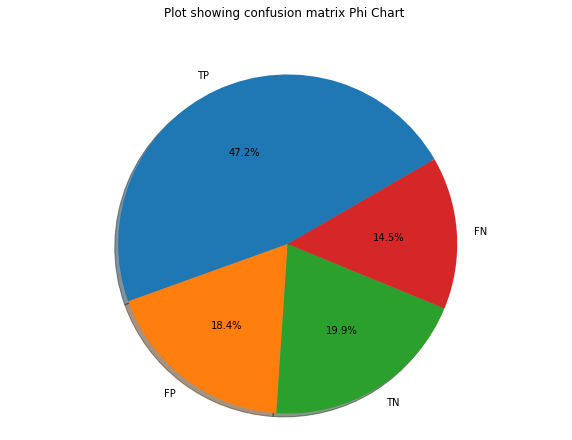

In [ ]:
path = r"/content/drive/MyDrive/M.Tech FYP/FYP_code/Analysis/"

Detection_results = pd.read_csv(path + 'CoMoFoD_Detection_mod3.csv')
info(Detection_results, dataset='CoMoFoD')

##### ROC when tested with dataset

In [ ]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 16})

# score = np.array([0, 0.25, 0.5, 1, 2, 4, 20, inf])

# false positive rate
FPR = [0, 0.17, 0.24, 0.38, 0.55, 0.752, 1]
# true positive rate
TPR = [0, 0.42, 0.6, 0.8, 0.93, 0.98, 1]

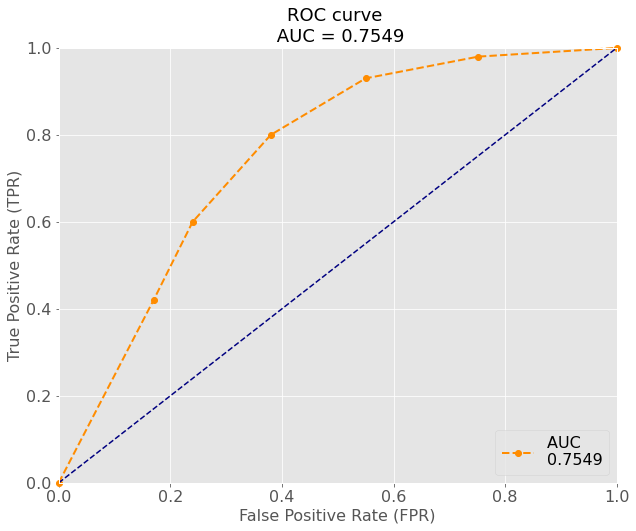

In [ ]:
auc = np.trapz(TPR, FPR)

plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label=f'AUC \n0.7549', clip_on=False)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)', fontsize=16)
plt.ylabel('True Positive Rate (TPR)', fontsize=16)
plt.title('ROC curve \n AUC = %.4f'%auc, fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('ROC_AUC.png')
plt.show()

____